In [1]:
# Network details: 
#                     !!!    pictures=4    !!! 
# ================
# this network is designed to decorrelate 4 pattern:
#         if you want to train only X pattern you only have to change
#            # number of training pictures: pictures=4 to pictures=X 
#         than the third training pattern will acts as test pattern only
#         
# the network will decorellate the training pattern
# the network has a correction term to conserve the number of active outputs (more or less)
# the network is made sensitive in weights to be able to decorrelate for never known inputs 


In [2]:
# include libraries
import numpy as np
import matplotlib.pyplot 
# ensure the plots are inside this notebook, not an external window
%matplotlib inline
import scipy as sc
from scipy import sparse
np.set_printoptions(precision=4)
import random
#--------------------------
# Set the number of change pixels
number_of_change_pixels=108 
rsaw=np.array(range(0,256)) #index of input array, will randomized by shuffel in every loop 
print("pixelselection rate =", (100*number_of_change_pixels/256),"%")

pixelselection rate = 42.1875 %


In [3]:
# decorrelationNetwork
class decorrelationNetwork:
    
    # initialise
    def __init__(self, inputnodes, outputnodes, sparsness, threshold_val, lerningrate):
        # set number of in- and outputnodes
        self.innodes=inputnodes
        self.outnodes=outputnodes
        self.sparsity=sparsness/2

        # lenght of inputpixel; quadratic size only
        self.__length=np.sqrt(self.innodes).astype(int)
        
        # threshold of output neurons
        self.th=threshold_val
        
        # initial matrix:
        # sparse random matrix
        self.woi=sc.sparse.rand(self.outnodes,self.innodes,self.sparsity,'coo',np.float64).toarray()-sc.sparse.rand(self.outnodes,self.innodes,self.sparsity,'coo',np.float64).toarray()

        #set lerningrate
        self.lr=lerningrate
        # activation function is heavyside function, lambda generates function
        self.activation_function = lambda x: np.heaviside(x-self.th,1)
        pass
# ========================================================================================================        
    def overwrite(self, inputnodes, outputnodes, sparsness, threshold_val, lerningrate):
        # set number of in- and outputnodes
        self.innodes=inputnodes
        self.outnodes=outputnodes
        self.sparsity=sparsness/2

        # lenght of inputpixel; quadratic size only
        self.__length=np.sqrt(self.innodes).astype(int)
        
        # threshold of output neurons
        self.th=threshold_val
        
        # initial matrix:
        # sparse random matrix
        self.woi=sc.sparse.rand(self.outnodes,self.innodes,self.sparsity,'coo',np.float64).toarray()-sc.sparse.rand(self.outnodes,self.innodes,self.sparsity,'coo',np.float64).toarray()

        #set lerningrate
        self.lr=lerningrate
        # activation function is heavyside function, lambda generates function
        self.activation_function = lambda x: np.heaviside(x-self.th,1)
        pass
# ========================================================================================================    
    # training
    def train(self, input_list, sensivity, thresholdadaption):
        # convert input list to 2d array
        # noise term for SDT otherwise the corrcoeff for known images =1 (added in training for consistency)
        # blending (unused): noise_input_list=(input_list+input_variation*np.random.uniform(0,1,input_nodes))/(1.0+input_variation)
        # but for pixelselection:
        noise_input_list=input_list.copy()
        random.shuffle(rsaw) 
        for i in range(number_of_change_pixels):
            noise_input_list[rsaw[i]]=np.random.uniform(0,1,1)
            pass
        # --------------
        inputs=np.array(noise_input_list, ndmin=2).T
        # input to secound (output) layer
        sec_in=np.dot(self.woi, inputs)
        # addaption of threshold is equivalent manipulate input to outputneuron
        thres_adaption=np.array(thresholdadaption, ndmin=2).T
        sec_input=np.add(sec_in,-thres_adaption)
        # calculate the output
        orthogonal_output=self.activation_function(sec_input)
        # =================================================================================================
        # (in)activate outputneurons of skiepattern is to far away from target number
        # activate 
        activations=(self.outnodes/4-sum(orthogonal_output))
        activations=np.int(activations) # .astype(int)
        inactivations=0
        if activations>10:       
            # randomly searching for inactiv outputneurons 
            chosen_neuron=np.random.randint(self.outnodes)
            while orthogonal_output[chosen_neuron]!=0:
                chosen_neuron=np.random.randint(self.outnodes)
                pass
            # build or increase connection unless the nuron is activated
            while orthogonal_output[chosen_neuron]==0:
                chosen_input=np.random.randint(self.innodes)
                while inputs[chosen_input]>(0.66+np.random.rand()/3):
                    chosen_input=np.random.randint(self.innodes)
                    pass
                self.woi[chosen_neuron][chosen_input]+=2.0*np.random.rand()
                sec_input=np.dot(self.woi, inputs)
                orthogonal_output=self.activation_function(sec_input)
            pass       
        elif activations<0:
            inactivations=-activations
            pass
        # ================   
        #decrease synaptic connetion or cut synaptic connetion if it is small -> to conserve sparsness
        if inactivations>10:
            # randomly searching for inactiv outputneurons 
            chosen_neuron=np.random.randint(self.outnodes)
            while orthogonal_output[chosen_neuron]!=1:
                chosen_neuron=np.random.randint(self.outnodes)
                pass
            # searching for small input values with statistical choise
            chosen_input=np.random.randint(self.innodes)
            while inputs[chosen_input]<(0.25-np.random.rand()/4):
                chosen_input=np.random.randint(self.innodes)
                pass 
            # cut synaptic connetion if it is small -> to conserve sparsness
            if (self.woi[chosen_neuron][chosen_input]>-sensivity and self.woi[chosen_neuron][chosen_input]<sensivity):
                self.woi[chosen_neuron][chosen_input]=0.0
            # or increase
            else:
                while orthogonal_output[chosen_neuron]==1:
                    self.woi[chosen_neuron][chosen_input]-=0.01*self.lr
                    sec_input=np.dot(self.woi, inputs)
                    orthogonal_output=self.activation_function(sec_input)
                    pass                
                pass
            pass      
        # ===============================================================================================
        # new calculation of output after manipulation
        orthogonal_output=self.activation_function(sec_input)
        #make the system more sensitive for new inputs
        randomize_neuron=np.random.randint(self.outnodes)  
        while orthogonal_output[randomize_neuron]!=0:
            randomize_neuron=np.random.randint(self.outnodes)
            pass    
        while (sec_input[randomize_neuron]+thres_adaption[randomize_neuron])>(self.th+sensivity):
            self.woi[randomize_neuron][:]*=0.95
            sec_input=np.dot(self.woi, inputs)
            pass
        randomize_neuron_inact=np.random.randint(self.outnodes)  
        while orthogonal_output[randomize_neuron_inact]!=1:
            randomize_neuron_inact=np.random.randint(self.outnodes)
            pass    
        while (sec_input[randomize_neuron_inact]+thres_adaption[randomize_neuron_inact])<(self.th-sensivity):
            self.woi[randomize_neuron_inact][:]*=1.05
            sec_input=np.dot(self.woi, inputs)
            pass
        return self.woi        
# ========================================================================================================     
    # Results
    def query(self, input_list, thresholdadaption):
        # convert input list to 2d array (was hier mit 2d gemeint ist und warum das 
        # konvertiert werden muss ist mir nicht klar, .T steht jedenfalls fuer Transponieren)
        # Rauschterm für SDT sonst ist der corrcoeff für bekannnte Bilder =1
        # blending: noise_input_list=(input_list+input_variation*np.random.uniform(0,1,input_nodes))/(1.0+input_variation)
        # doch fuer Pixelselection:
        noise_input_list=input_list.copy()
        random.shuffle(rsaw) 
        for i in range(number_of_change_pixels):
            noise_input_list[rsaw[i]]=np.random.uniform(0,1,1)
            pass
        # --------------
        inputs=np.array(noise_input_list, ndmin=2).T
        # input to secound (output) layer
        sec_in=np.dot(self.woi, inputs)
        # addaption of threshold is equivalent manipulate input
        thres_adaption=np.array(thresholdadaption, ndmin=2).T
        sec_input=np.add(sec_in,-thres_adaption)
        orthogonal_output=self.activation_function(sec_input)
        return orthogonal_output

In [4]:
# set parameter to initilise

# number of training pictures
pictures=4
# number of in- outputnodes and lerningrate
input_nodes=256
length_in=np.sqrt(input_nodes).astype(int)
output_nodes=1024
length_out=np.sqrt(output_nodes).astype(int)
lerning_rate=0.3

# sparseness of random connections from EC to DG (perforant path) 
sparse_factor=0.05

# threshold of output neurons
threshold=0.85
sensibility_factor=0.15 
threshold_correction=np.zeros(output_nodes)

# create instance of decorrelation network
dn=decorrelationNetwork(input_nodes, output_nodes, sparse_factor, threshold, lerning_rate)

In [5]:
probanden=100   #number of probands
Proband_No=0    #index of probands starting at null
for prob in range(probanden):  
    dn.overwrite(input_nodes, output_nodes, sparse_factor, threshold, lerning_rate)
    # sparseness of random connections
    sparse_factor=0.05

    # threshold of output neurons
    threshold=0.85
    sensibility_factor=0.15 
    threshold_correction=np.zeros(output_nodes)
    # create training data with correlations <0.1
    # create faulty matrix so that it goes into the loop
    input_correlation=np.ones((5,5))
    Proband_No+=1
    print(Proband_No)
    while (np.abs(input_correlation[0,1])>0.1 or np.abs(input_correlation[0,2])>0.1 or np.abs(input_correlation[0,3])>0.1 or np.abs(input_correlation[1,2])>0.1 or np.abs(input_correlation[1,3])>0.1 or np.abs(input_correlation[2,3])>0.1 ):
        data_01=np.random.uniform(0,1,input_nodes)
        data_02=np.random.uniform(0,1,input_nodes)
        data_03=np.random.uniform(0,1,input_nodes)
        data_04=np.random.uniform(0,1,input_nodes)
        indat = [np.array(data_01), np.array(data_02), np.array(data_03), np.array(data_04)]
        input_data = np.array(indat)
        input_correlation=np.corrcoef(input_data)
        #input_correlation
        pass
    # train the neural network and show sparsness of trained matrix
    # epochs is the number of times the training data set is used for training
    epochs = 25
    for e in range(epochs):
        total_output=np.zeros(output_nodes).T
        for p in range(pictures):
            woi=dn.train(input_data[p], sensibility_factor, threshold_correction)
            total_output=np.add(total_output,dn.query(input_data[p], threshold_correction).T)
            pass 
        for pix in range (output_nodes):
            if total_output[0][pix]>np.random.randint(1,np.max(total_output)) and threshold_correction[pix]<1.5:
                threshold_correction[pix]+=0.02*total_output[0][pix]*np.random.rand()
                pass
            pass
        pass 
        
    final_woi=woi.copy()
    np.place(final_woi, final_woi>0, 1)
    np.place(final_woi, final_woi<0, 1)
    sum_colum=sum(final_woi)
    final_sparsness=sum(sum_colum)/(input_nodes*output_nodes)
    
    druchlaeufe=25 # number of runs 
    fo = open("file.txt", "a")
    for durchl in range(druchlaeufe):
        noise_pattern=np.random.uniform(0,1,input_nodes)
        tastschritte=7 #sampling rate= 1/Tastschritte 
        for ts in range(tastschritte+1):
            # convert for equal correlation steps:
            if ts==0:
                tsblq=0
                pass
            if ts>0:
                tsq=ts*(1/(tastschritte)) #equidistant distances
                tsblq=1/(1+np.sqrt((1/np.power(tsq,2))-1))  #equidistant distances when blending is taken into account
                pass
            testdata_a=tsblq*input_data[0].copy()+(1-tsblq)*noise_pattern.copy()
            testdata_b=tsblq*input_data[1].copy()+(1-tsblq)*noise_pattern.copy()
            testdata_c=tsblq*input_data[2].copy()+(1-tsblq)*noise_pattern.copy()
            testdata_d=tsblq*input_data[3].copy()+(1-tsblq)*noise_pattern.copy()
            testout_a=dn.query(testdata_a, threshold_correction)
            testout_b=dn.query(testdata_b, threshold_correction)
            testout_c=dn.query(testdata_c, threshold_correction)
            testout_d=dn.query(testdata_d, threshold_correction)
            if ts==0:
                testoutput_a=testout_a.T
                testoutput_b=testout_b.T
                testoutput_c=testout_c.T
                testoutput_d=testout_d.T
                pass
            if ts>0:
                testoutput_a=np.append(testoutput_a, testout_a.T, axis=0)
                testoutput_b=np.append(testoutput_b, testout_b.T, axis=0)
                testoutput_c=np.append(testoutput_c, testout_c.T, axis=0)
                testoutput_d=np.append(testoutput_d, testout_d.T, axis=0)
        
                pass
            pass 
        #Create comparison pattern:
        testout_a=dn.query(input_data[0], threshold_correction)
        testout_b=dn.query(input_data[1], threshold_correction)
        testout_c=dn.query(input_data[2], threshold_correction)
        testout_d=dn.query(input_data[3], threshold_correction)
        testoutput_a=np.append(testoutput_a, testout_a.T, axis=0)
        testoutput_b=np.append(testoutput_b, testout_b.T, axis=0)
        testoutput_c=np.append(testoutput_c, testout_c.T, axis=0)
        testoutput_d=np.append(testoutput_d, testout_d.T, axis=0)
        #compute correlations:
        output_correlation_01=np.corrcoef(testoutput_a)
        output_correlation_02=np.corrcoef(testoutput_b)
        output_correlation_03=np.corrcoef(testoutput_c)
        output_correlation_04=np.corrcoef(testoutput_d)
 
        fo.write('\n%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf' %(output_correlation_01[7,0],output_correlation_01[7,1],output_correlation_01[7,2],output_correlation_01[7,3],output_correlation_01[7,4],output_correlation_01[7,5],output_correlation_01[7,6]))
        fo.write('\n%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf' %(output_correlation_02[7,0],output_correlation_02[7,1],output_correlation_02[7,2],output_correlation_02[7,3],output_correlation_02[7,4],output_correlation_02[7,5],output_correlation_02[7,6]))  
        fo.write('\n%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf' %(output_correlation_03[7,0],output_correlation_03[7,1],output_correlation_03[7,2],output_correlation_03[7,3],output_correlation_03[7,4],output_correlation_03[7,5],output_correlation_03[7,6]))  
        fo.write('\n%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf\t%.4lf' %(output_correlation_04[7,0],output_correlation_04[7,1],output_correlation_04[7,2],output_correlation_04[7,3],output_correlation_04[7,4],output_correlation_04[7,5],output_correlation_04[7,6]))  
        pass
    fo.close()
    pass


1
2
3
4
5
6
7
8
9
10


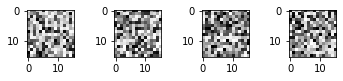

In [9]:
# show input pattern 1
image_array_01 = input_data[0].reshape((length_in,length_in)) 
image_array_02 = input_data[1].reshape((length_in,length_in))
image_array_03 = input_data[2].reshape((length_in,length_in)) 
image_array_04 = input_data[3].reshape((length_in,length_in))
matplotlib.pyplot.subplot(4, 4, 1)
matplotlib.pyplot.imshow(image_array_01, cmap='Greys', interpolation='None')
matplotlib.pyplot.subplot(4, 4, 2)
matplotlib.pyplot.imshow(image_array_02, cmap='Greys', interpolation='None')
matplotlib.pyplot.subplot(4, 4, 3)
matplotlib.pyplot.imshow(image_array_03, cmap='Greys', interpolation='None')
matplotlib.pyplot.subplot(4, 4, 4)
matplotlib.pyplot.imshow(image_array_04, cmap='Greys', interpolation='None')

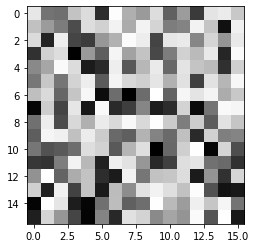

In [7]:
# example of a EC pattern (continous)
matplotlib.pyplot.imshow(image_array_01, cmap='Greys', interpolation='None')

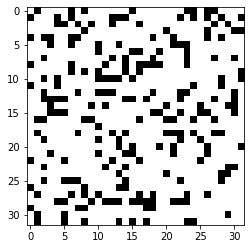

In [11]:
# example of a DG pattern (binary)
image_array_02 = testoutput_a[6].reshape((32,32))
matplotlib.pyplot.imshow(image_array_02, cmap='Greys', interpolation='None')